In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime

import xgboost as xgb

In [3]:
DF_train = pd.read_csv('Train.csv')
DF_test  = pd.read_csv('Test.csv')


In [4]:
#Dropping some outliers compared to test
print(DF_train.shape)
DF_train = DF_train.loc[((DF_train.rain_p_h < 11) & (DF_train.temperature !=0)),]
#DF_train = DF_train.loc[((DF_train.temperature !=0)),]
print(DF_train.shape)


# Combining the train and test
DF_test['traffic_volume'] = np.nan
print(DF_train.shape, DF_test.shape)
DF_prod = pd.concat([DF_train, DF_test])
print(DF_prod.shape)

(33750, 15)
(33664, 15)
(33664, 15) (14454, 15)
(48118, 15)


In [5]:
# Dropping the outliers
print(DF_prod.shape)
DF_prod = DF_prod.loc[DF_prod.rain_p_h != DF_prod.rain_p_h.max(),]
print(DF_prod.shape)

#Correcting the date format
DF_prod['date_time'] = pd.to_datetime(DF_prod.date_time)


(48118, 15)
(48115, 15)


In [6]:
# Extending the holiday to the entire day
temp = DF_prod.loc[DF_prod.is_holiday != 'None', ['date_time','is_holiday']]
temp['date_time'] = temp['date_time'].dt.date
temp = temp.loc[~temp.duplicated(),]
print(temp.shape)
temp.head()

print(DF_prod.shape)
#Merging it to the dataframe
DF_prod = DF_prod.merge(temp, how = 'left', 
                            left_on = [DF_prod['date_time'].dt.date], 
                            right_on = ['date_time']).drop(['date_time', 'date_time_y', 'is_holiday_x'], axis = 1).rename(columns = {'date_time_x' : 'date_time', 
                                                                                                                                     'is_holiday_y' : 'is_holiday'})
print(DF_prod.shape)
DF_prod.loc[DF_prod.is_holiday.isnull(), ['is_holiday']] = 'None'
DF_prod.is_holiday.value_counts()

(53, 2)
(48115, 15)
(48115, 15)


None                         46706
Labor Day                      157
Washingtons Birthday           136
Thanksgiving Day               135
Memorial Day                   134
Christmas Day                  131
New Years Day                  131
Independence Day               126
Veterans Day                   120
State Fair                     120
Columbus Day                   112
Martin Luther King Jr Day      107
Name: is_holiday, dtype: int64

# Feature Engineering

In [58]:
DF = DF_prod.copy()
DF['day'] = DF.date_time.dt.day
DF['month'] = DF.date_time.dt.month
DF['year'] = DF.date_time.dt.year
DF['hour'] = DF.date_time.dt.hour
#DF['quarter'] = DF.date_time.dt.quarter
#DF.drop(['date_time'], axis = 1, inplace = True)
DF['weekday_number'] = DF.date_time.dt.dayofweek
DF['week_number'] = DF.date_time.dt.week
DF['weekday'] = np.where(DF.date_time.dt.dayofweek < 5, 1, 0)
DF['holiday'] = np.where(DF.is_holiday == 'None', 0, 1)

#DF.loc[DF['weekday'] == 0, ['holiday']] = 1

DF['weekday_plus_holiday'] = np.where((DF['weekday'] + DF['holiday']) == 2, 1 ,0)
DF['wind_direction_NSEW'] = np.where((DF.wind_direction >= 0) & (DF.wind_direction < 90) , 'North_East', 
                                    np.where((DF.wind_direction >= 90) & (DF.wind_direction < 180) , 'South_East', 
                                            np.where((DF.wind_direction >= 180) & (DF.wind_direction < 270) , 'South_West', 'North_West')))

DF['long_weekend'] = np.where(((DF.holiday == 1) & 
                              (DF.weekday_number.isin([0,4]))), 1, 0)

#DF.head()

In [59]:
# DF['temperature_rolling_5_min'] = DF.temperature.rolling(5).min()
# DF['temperature_rolling_5_max'] = DF.temperature.rolling(5).max()
# DF['temperature_rolling_5_std'] = DF.temperature.rolling(5).std()

# DF['temperature_rolling_3_min'] = DF.temperature.rolling(3).min()
# DF['temperature_rolling_3_max'] = DF.temperature.rolling(3).max()
# DF['temperature_rolling_3_std'] = DF.temperature.rolling(3).std()

# DF['air_pollution_index_5_min'] = DF.air_pollution_index.rolling(5).min()
# DF['air_pollution_index_5_max'] = DF.air_pollution_index.rolling(5).max()
# DF['air_pollution_index_5_std'] = DF.air_pollution_index.rolling(5).std()

# DF['air_pollution_index_3_min'] = DF.air_pollution_index.rolling(3).min()
# DF['air_pollution_index_3_max'] = DF.air_pollution_index.rolling(3).max()
# DF['air_pollution_index_3_std'] = DF.air_pollution_index.rolling(3).std()


# DF['temperature_rolling_5_median'] = DF.temperature.rolling(5).median()
# DF['temperature_rolling_5_mean'] = DF.temperature.rolling(5).mean()

# DF['humidity_rolling_5_min'] = DF.humidity.rolling(5).min()
# DF['humidity_rolling_5_max'] = DF.humidity.rolling(5).max()
# DF['humidity_rolling_5_std'] = DF.humidity.rolling(5).std()


In [60]:
DF['seasons'] = np.where(DF.date_time.dt.month.isin([3,4,5]),'Spring',
                         np.where(DF.date_time.dt.month.isin([6,7,8]),'Summer',
                                  np.where(DF.date_time.dt.month.isin([9,10,11]),'Fall','Winter')))

In [61]:
DF['peak_hour']= np.where(((DF.hour>=6) & (DF.hour<=8)) | ((DF.hour>=15) & (DF.hour<=17)), 1, 0)
#DF['peak_week_day'] = np.where((DF['peak_hour'] + DF['weekday'] ==2), 1, 0)

day_time_start = datetime.time(6,00,00)
afternoon_time_start = datetime.time(11,00,00)
evening_start_time = datetime.time(15,00,00)
night_time_start = datetime.time(20,00,00)

# DF['part_of_day'] = np.where(((DF['date_time'].dt.time > day_time_start) & (DF['date_time'].dt.time <= afternoon_time_start)), 'Morning', 
#                              np.where(((DF['date_time'].dt.time > afternoon_time_start) & (DF['date_time'].dt.time <= evening_start_time)), 'Afternoon', 
#                                      np.where(((DF['date_time'].dt.time > evening_start_time) & (DF['date_time'].dt.time <= night_time_start)), 'Evening', 'Nighttime')))  

DF['part_of_day'] = np.where(((DF['date_time'].dt.time > day_time_start) & (DF['date_time'].dt.time <= afternoon_time_start)), 0, 
                             np.where(((DF['date_time'].dt.time > afternoon_time_start) & (DF['date_time'].dt.time <= evening_start_time)), 1, 
                                     np.where(((DF['date_time'].dt.time > evening_start_time) & (DF['date_time'].dt.time <= night_time_start)), 2, 3)))  

day_light_start = datetime.time(6,00,00)
night_time_start = datetime.time(20,00,00)
DF['Day_light'] = np.where(((DF['date_time'].dt.time >= day_light_start) & (DF['date_time'].dt.time <= night_time_start)), 1, 0)


DF['temperature_lag_1'] = DF.temperature.shift(1)
# DF['temperature_lag_2'] = DF.temperature.shift(2)
# DF['temperature_lag_3'] = DF.temperature.shift(3)

# DF['rain_p_h_lag_1'] = DF.rain_p_h.shift(1)
# DF['rain_p_h_lag_2'] = DF.rain_p_h.shift(2)
# DF['rain_p_h_lag_3'] = DF.rain_p_h.shift(3)

# DF['holiday_next_day'] = DF.holiday.shift(1)
# DF['holiday_previous_day'] = DF.temperature.shift(-1)
# DF['humidity_lag_2'] = DF.humidity.shift(2)
# DF['humidity_lag_3'] = DF.humidity.shift(3)

# mean_temperature = DF[['date_time','temperature']].groupby([DF['date_time'].dt.date])['temperature'].mean().reset_index().rename(columns = {'temperature':'mean_temperature'})  
# mean_temperature['mean_temperature_lag_1'] = mean_temperature['mean_temperature'].shift(1)


# DF = DF.merge(mean_temperature[['date_time', 'mean_temperature_lag_1']], 
#               how = 'left', left_on = [DF['date_time'].dt.date], 
#               right_on = ['date_time']).drop(['date_time', 'date_time_y'], axis = 1).rename(columns = {'date_time_x' : 'date_time'})

DF.head()

,date_time,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,...,weekday,holiday,weekday_plus_holiday,wind_direction_NSEW,long_weekend,seasons,peak_hour,part_of_day,Day_light,temperature_lag_1
0,2012-10-02 09:00:00,121,89,2,329,1,1,288.28,0.0,0.0,...,1,0,0,North_West,0,Fall,0,0,1,NaN
1,2012-10-02 10:00:00,178,67,3,330,1,1,289.36,0.0,0.0,...,1,0,0,North_West,0,Fall,0,0,1,288.28
2,2012-10-02 11:00:00,113,66,3,329,2,2,289.58,0.0,0.0,...,1,0,0,North_West,0,Fall,0,0,1,289.36
3,2012-10-02 12:00:00,20,66,3,329,5,5,290.13,0.0,0.0,...,1,0,0,North_West,0,Fall,0,1,1,289.58
4,2012-10-02 13:00:00,281,65,3,329,7,7,291.14,0.0,0.0,...,1,0,0,North_West,0,Fall,0,1,1,290.13


In [62]:
#Next day and previous day holiday
temp = DF[['date_time', 'holiday']]
temp['date_time'] = temp['date_time'].dt.date
print(temp.shape)
temp = temp.loc[~temp.duplicated(),]
print(temp.shape)
temp['previous_day_holiday'] = temp['holiday'].shift(1)
temp['next_day_holiday'] = temp['holiday'].shift(-1)

DF = DF.merge(temp[['date_time', 'previous_day_holiday', 'next_day_holiday']], 
              how = 'left', left_on = [DF['date_time'].dt.date], 
              right_on = ['date_time']).drop(['date_time', 'date_time_y'], axis = 1).rename(columns = {'date_time_x' : 'date_time'})


C:\Users\BTHANISH\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(48115, 2)
(1860, 2)


In [63]:
# Forming the turbulence index for each day
temp = DF.groupby([DF.date_time.dt.date])['wind_speed'].agg(['mean','std']).reset_index()
temp['turbulence_index'] = temp['std']/temp['mean']
print(temp.head())

DF = DF.merge(temp[['date_time','turbulence_index']], how = 'left', left_on = [DF.date_time.dt.date] , right_on = [temp.date_time]).drop(['key_0', 'date_time_y'], axis =1).rename(columns ={'date_time_x': 'date_time'})    
#DF.head()

# Forming the temperature index for each day
temp = DF.groupby([DF.date_time.dt.date])['temperature'].agg(['mean','std']).reset_index()
temp['temperature_index'] = temp['std']/temp['mean']
print(temp.head())

DF = DF.merge(temp[['date_time', 'temperature_index']], how = 'left', left_on = [DF.date_time.dt.date] , right_on = [temp.date_time]).drop(['key_0', 'date_time_y'], axis =1).rename(columns ={'date_time_x': 'date_time'})        

DF.head()

    date_time      mean       std  turbulence_index
0  2012-10-02  3.133333  0.516398          0.164808
1  2012-10-03  4.400000  0.882580          0.200586
2  2012-10-04  2.666667  1.992740          0.747278
3  2012-10-05  2.181818  1.097025          0.502803
4  2012-10-06  5.739130  3.048359          0.531153
    date_time        mean       std  temperature_index
0  2012-10-02  290.403333  2.522792           0.008687
1  2012-10-03  286.413500  6.046798           0.021112
2  2012-10-04  289.357500  6.470654           0.022362
3  2012-10-05  282.078182  3.438235           0.012189
4  2012-10-06  277.746087  1.623245           0.005844


,date_time,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,...,long_weekend,seasons,peak_hour,part_of_day,Day_light,temperature_lag_1,previous_day_holiday,next_day_holiday,turbulence_index,temperature_index
0,2012-10-02 09:00:00,121,89,2,329,1,1,288.28,0.0,0.0,...,0,Fall,0,0,1,NaN,NaN,0.0,0.164808,0.008687
1,2012-10-02 10:00:00,178,67,3,330,1,1,289.36,0.0,0.0,...,0,Fall,0,0,1,288.28,NaN,0.0,0.164808,0.008687
2,2012-10-02 11:00:00,113,66,3,329,2,2,289.58,0.0,0.0,...,0,Fall,0,0,1,289.36,NaN,0.0,0.164808,0.008687
3,2012-10-02 12:00:00,20,66,3,329,5,5,290.13,0.0,0.0,...,0,Fall,0,1,1,289.58,NaN,0.0,0.164808,0.008687
4,2012-10-02 13:00:00,281,65,3,329,7,7,291.14,0.0,0.0,...,0,Fall,0,1,1,290.13,NaN,0.0,0.164808,0.008687


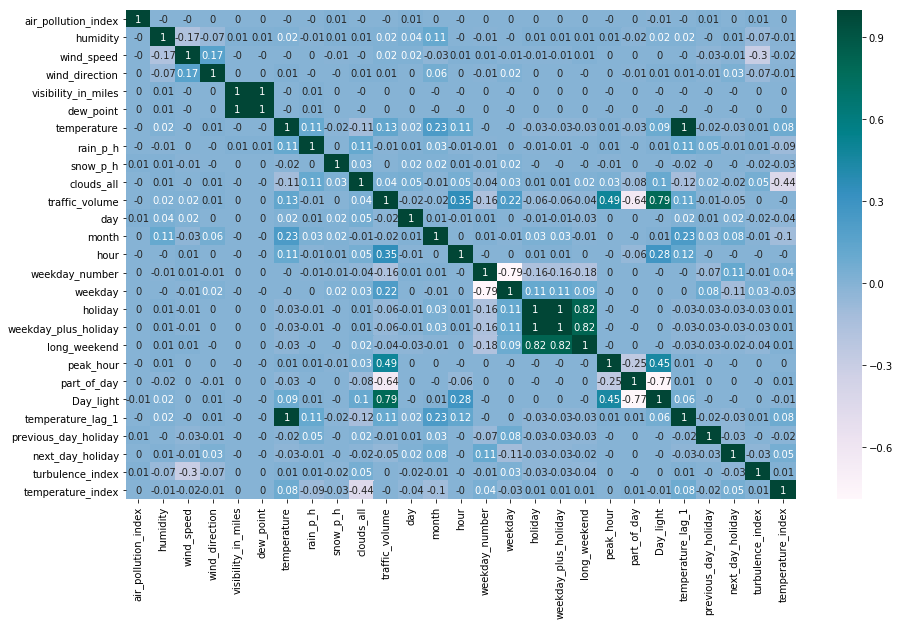

In [13]:
#sns.heatmap
plt.figure(figsize = (15, 9))
sns.heatmap(np.round(DF.corr(),2), annot=True, cmap="PuBuGn")
plt.show()

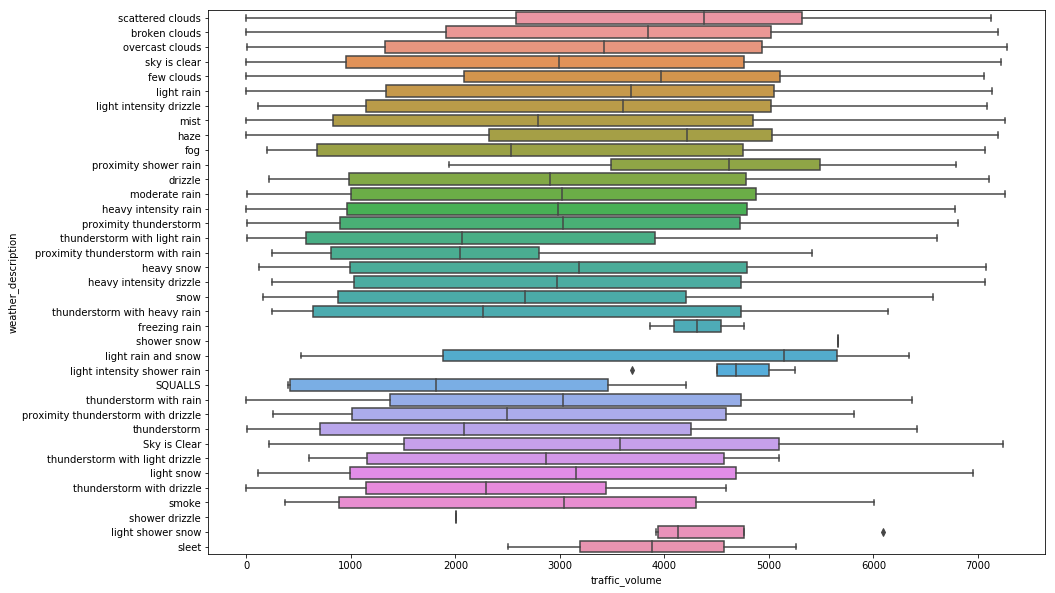

In [30]:
plt.figure(figsize = (15, 10))
sns.boxplot(x = DF.traffic_volume, y = DF.weather_description)
plt.show()

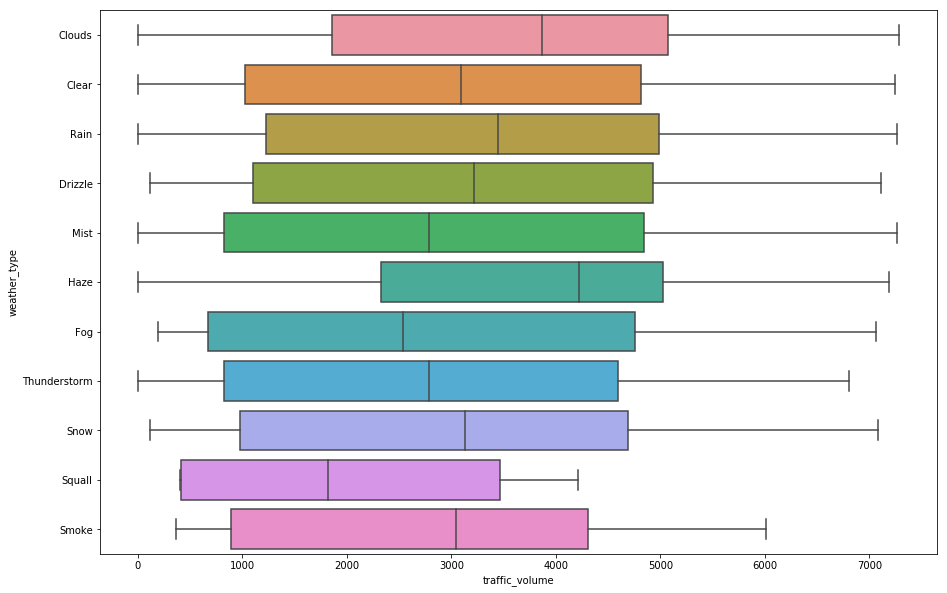

In [31]:
plt.figure(figsize = (15, 10))
sns.boxplot(x = DF.traffic_volume, y = DF.weather_type)
plt.show()

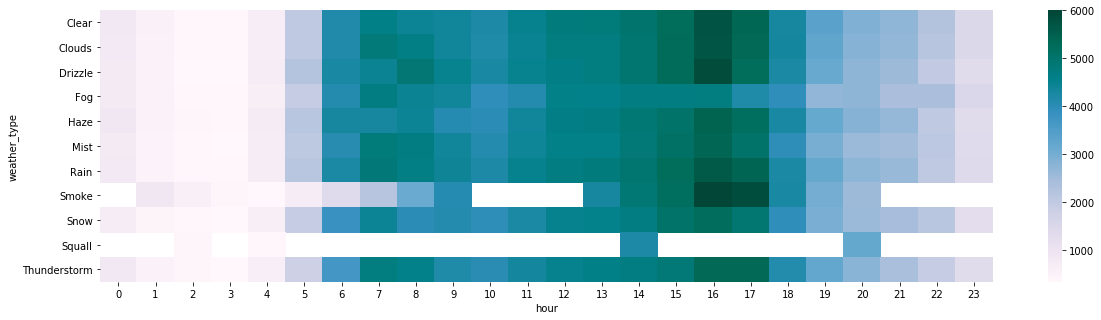

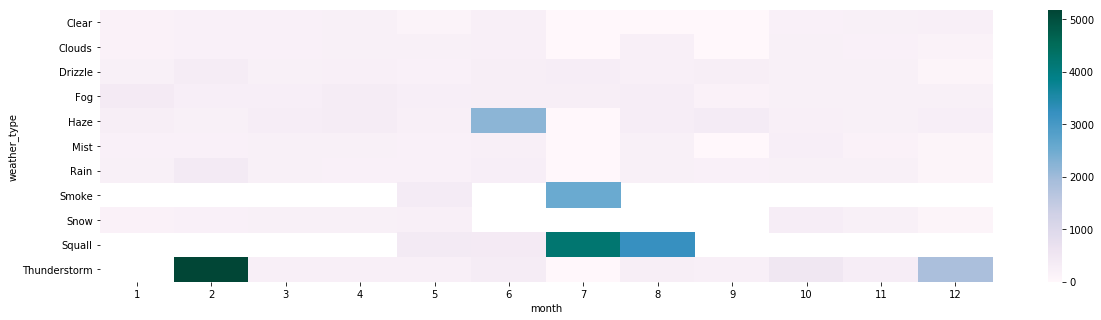

In [39]:
plt.figure(figsize = (20,5))
df_heat = DF.groupby(["weather_type", "hour"])["traffic_volume"].mean().reset_index()
df_heat2 = df_heat.pivot("weather_type", "hour", "traffic_volume")#sns.heatmap( , cmap="YlGnBu")
df_heat2.head()

sns.heatmap(df_heat2, cmap="PuBuGn")
plt.show()

plt.figure(figsize = (20,5))
df_heat = DF.groupby(["weather_type", "month"])["traffic_volume"].min().reset_index()
df_heat2 = df_heat.pivot("weather_type", "month", "traffic_volume")#sns.heatmap( , cmap="YlGnBu")
df_heat2.head()

sns.heatmap(df_heat2, cmap="PuBuGn")
plt.show()

In [78]:
# Traffic across week
DF.year.unique()

(array([2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype=int64),
 array([2012, 2013, 2014, 2015, 2016, 2017, 2018], dtype=int64))

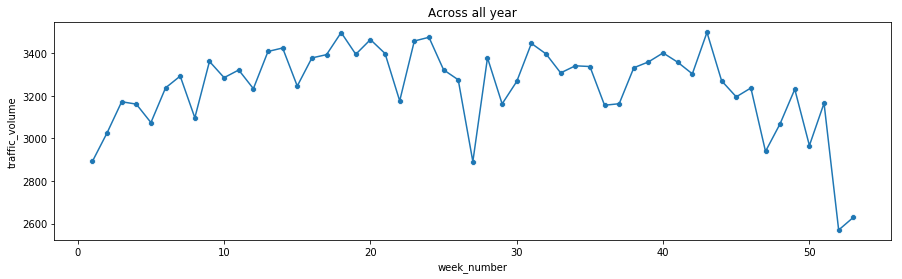

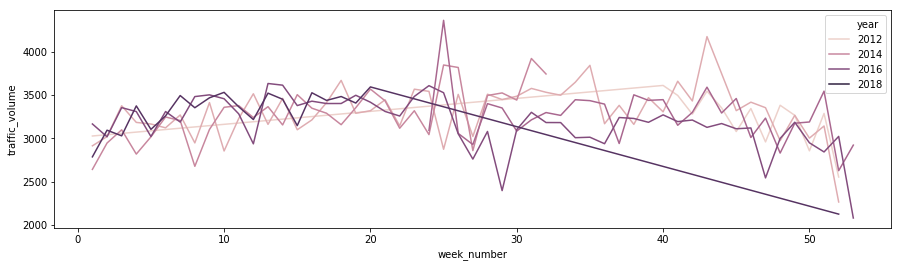

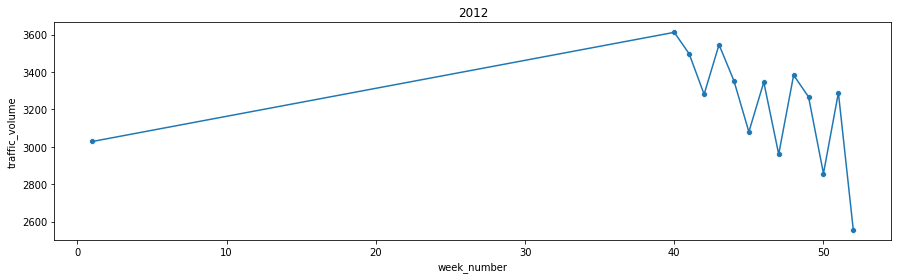

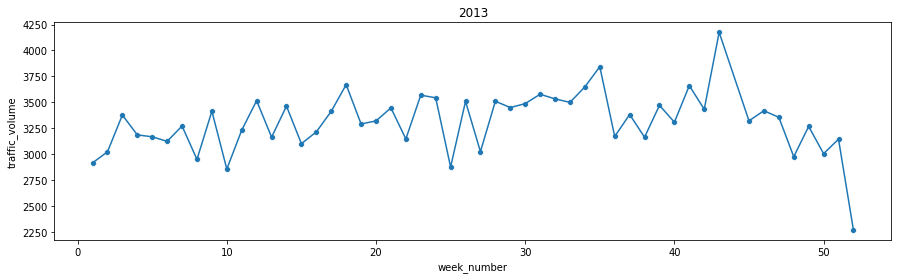

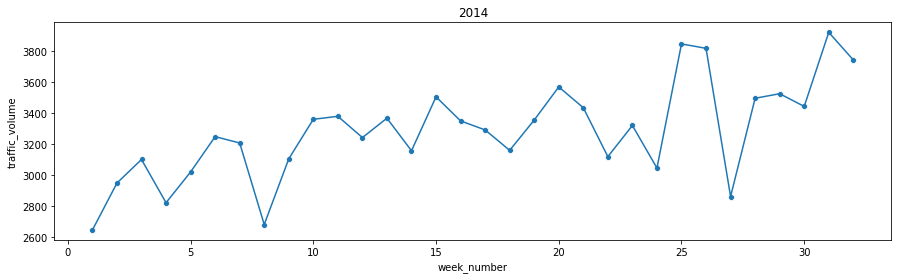

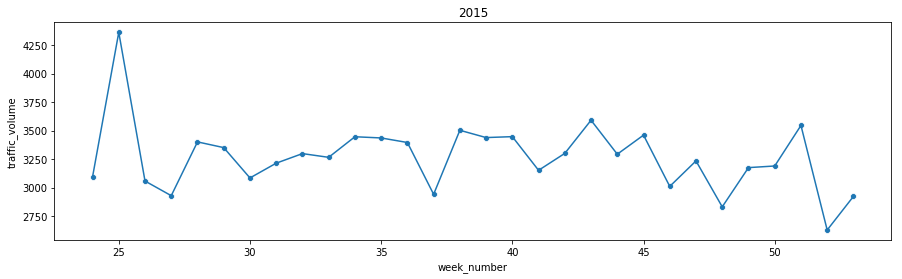

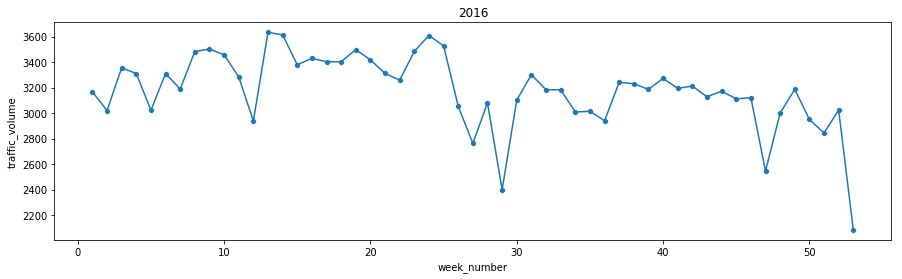

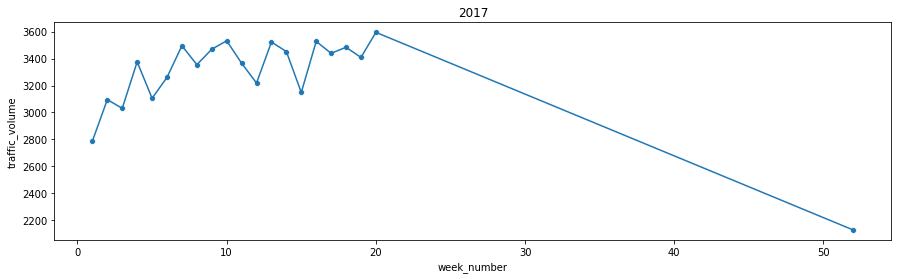

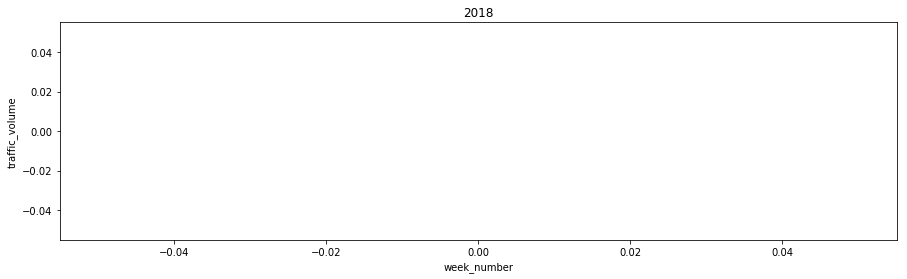

In [91]:
plt.figure(figsize = (15,4))
df_heat = DF.groupby(["week_number"])["traffic_volume"].mean().reset_index()
sns.scatterplot(df_heat.week_number, df_heat.traffic_volume)
sns.lineplot(df_heat.week_number, df_heat.traffic_volume)
plt.title("Across all year")
plt.show()

plt.figure(figsize = (15, 4))
temp = DF.groupby(['year',"week_number"])["traffic_volume"].mean().reset_index()
sns.lineplot(temp.week_number, temp.traffic_volume, hue=temp.year)
plt.show()
    
for year in temp.year.unique():
    plt.figure(figsize = (15,4))
    temp_v1 = temp.loc[temp.year == year,]
    sns.scatterplot(temp_v1.week_number, temp_v1.traffic_volume)
    sns.lineplot(temp_v1.week_number, temp_v1.traffic_volume)
    plt.title(year)
    plt.show()


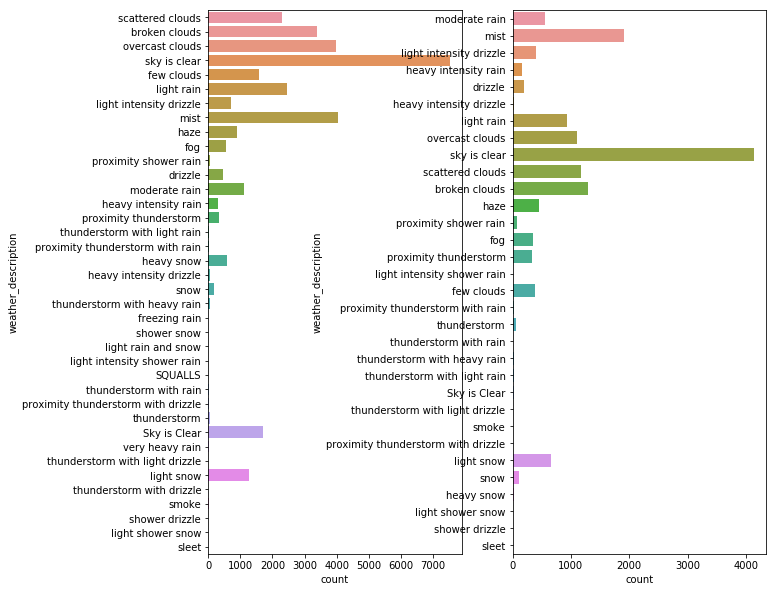

In [4]:
plt.figure(figsize = (10,10))
plt.subplot(121)
sns.countplot(y=DF['weather_description'][DF.type == 'train'])


plt.subplot(122)
sns.countplot(y=DF['weather_description'][DF.type == 'test'])
#plt.axis('off')
plt.show()

C:\Users\BTHANISH\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


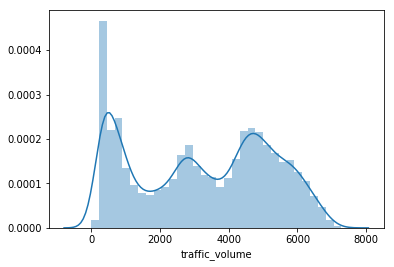

In [11]:
sns.distplot(DF['traffic_volume'][DF.type != 'test'])
plt.show()

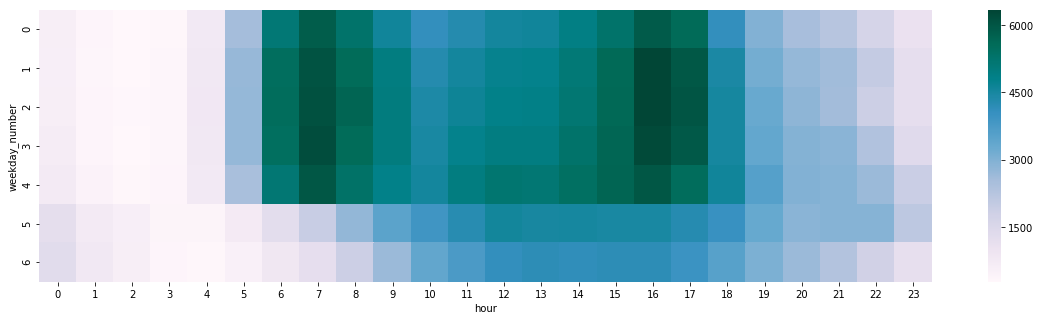

In [13]:
plt.figure(figsize = (20,5))
df_heat = DF.groupby(["weekday_number", "hour"])["traffic_volume"].mean().reset_index()
df_heat2 = df_heat.pivot("weekday_number", "hour", "traffic_volume")#sns.heatmap( , cmap="YlGnBu")
df_heat2.head()

sns.heatmap(df_heat2, cmap="PuBuGn")
plt.show()


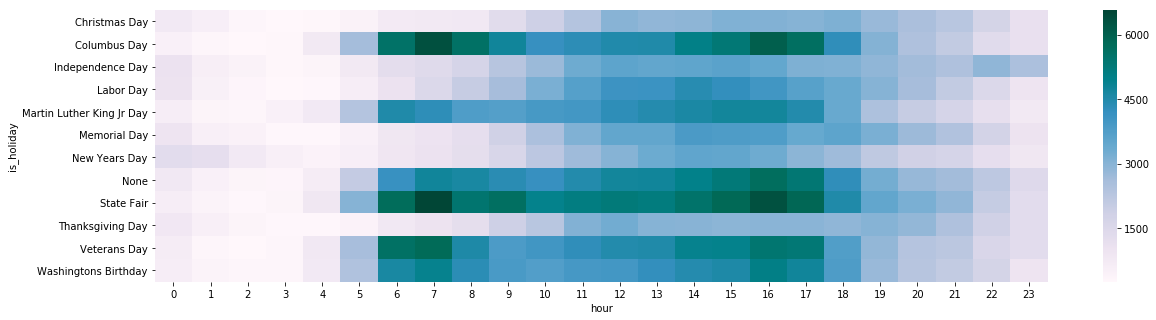

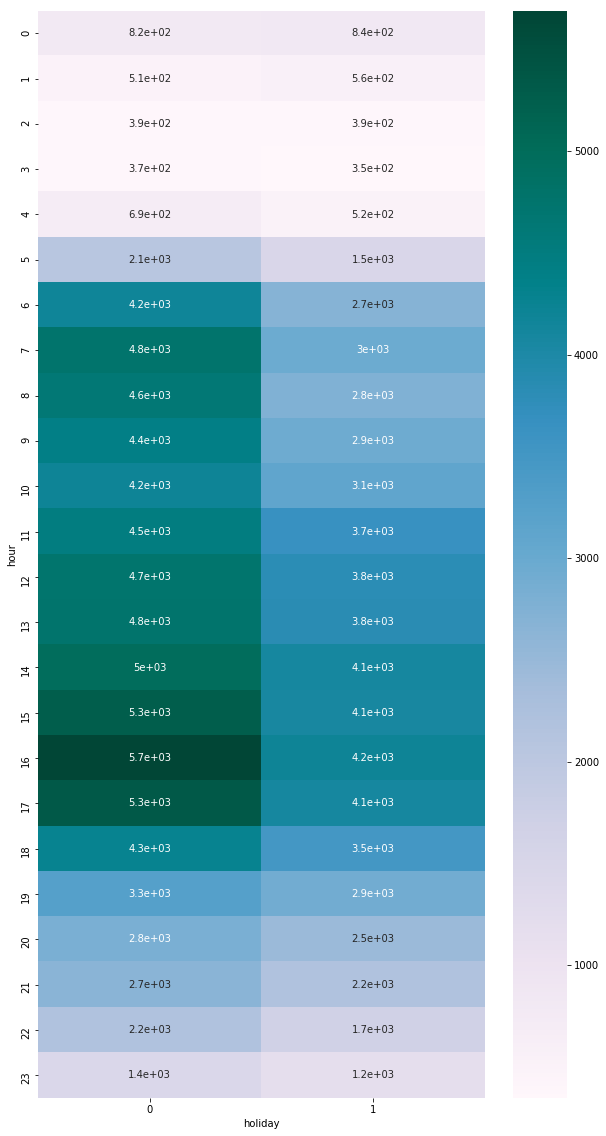

In [92]:
plt.figure(figsize = (20,5))
df_heat = DF.groupby(["is_holiday", "hour"])["traffic_volume"].mean().reset_index()
df_heat2 = df_heat.pivot("is_holiday", "hour", "traffic_volume")#sns.heatmap( , cmap="YlGnBu")
df_heat2.head()

sns.heatmap(df_heat2, cmap="PuBuGn")
plt.show()


plt.figure(figsize = (10,20))
df_heat = DF.groupby(["hour", "holiday"])["traffic_volume"].mean().reset_index()
df_heat2 = df_heat.pivot("hour", "holiday", "traffic_volume")#sns.heatmap( , cmap="YlGnBu")
df_heat2.head()

sns.heatmap(df_heat2, cmap="PuBuGn", annot = True)
plt.show()

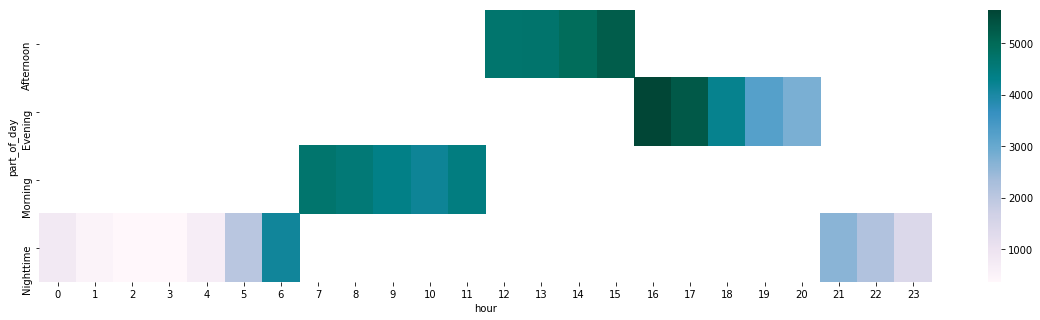

In [56]:
plt.figure(figsize = (20,5))
df_heat = DF.groupby(["part_of_day", "hour"])["traffic_volume"].mean().reset_index()
df_heat2 = df_heat.pivot("part_of_day", "hour", "traffic_volume")#sns.heatmap( , cmap="YlGnBu")
df_heat2.head()

sns.heatmap(df_heat2, cmap="PuBuGn")
plt.show()


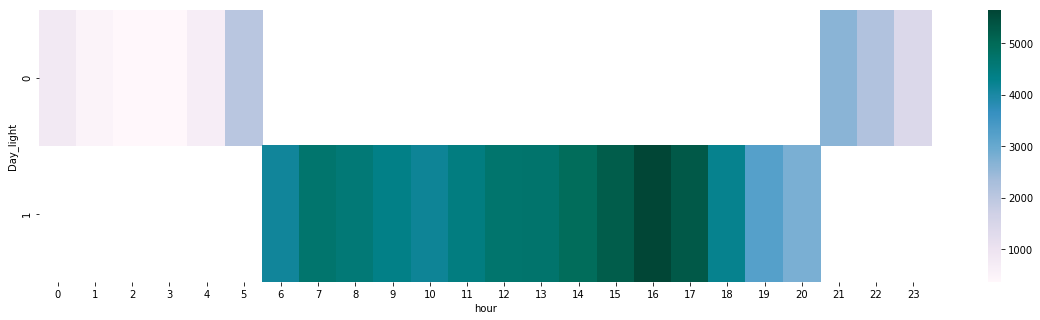

In [57]:

plt.figure(figsize = (20,5))
df_heat = DF.groupby(["Day_light", "hour"])["traffic_volume"].mean().reset_index()
df_heat2 = df_heat.pivot("Day_light", "hour", "traffic_volume")#sns.heatmap( , cmap="YlGnBu")
df_heat2.head()

sns.heatmap(df_heat2, cmap="PuBuGn")
plt.show()


In [1]:
sns.distplot(DF.weekday_number, kde=False)
plt.show()

NameError: name 'sns' is not defined

C:\Users\BTHANISH\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


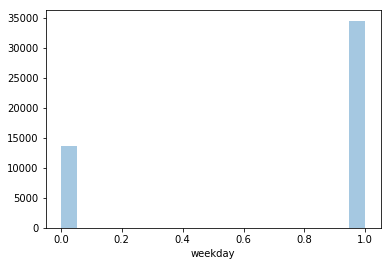

In [19]:
sns.distplot(DF.weekday, kde=False)
plt.show()

C:\Users\BTHANISH\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


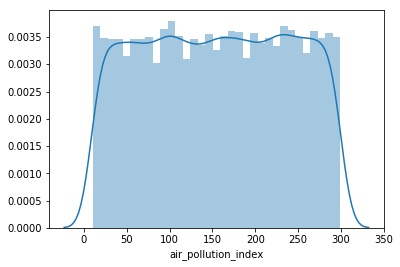

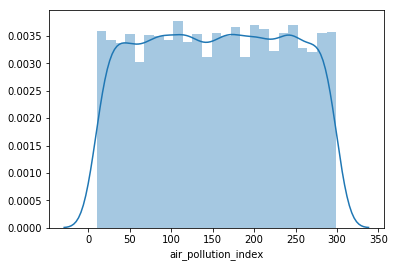

In [22]:
sns.distplot(DF['air_pollution_index'][DF.type == 'train'])
plt.show()

sns.distplot(DF['air_pollution_index'][DF.type == 'test'])
plt.show()


C:\Users\BTHANISH\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


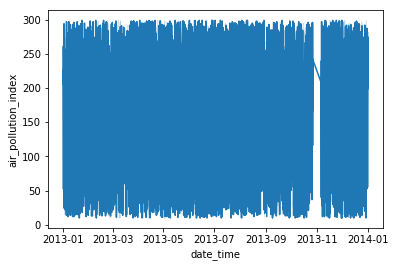

In [26]:
sns.lineplot(DF.date_time[DF.year == 2013], 
             DF.air_pollution_index[DF.year == 2013])
plt.show()